In [13]:
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# データの読み込み
path = "./stock_price.csv"
df = pd.read_csv(path)

In [ ]:
# 前処理
df = df.rename(
    columns={
        "終値": "Close",
        "始値": "Open",
        "高値": "High",
        "安値": "Low",
        "出来高": "Volume",
        "変化率 %": "Change",
    },
    index=str,
)
df.index.name = "Date"

symbols = set()
for value in df["Volume"]:
    symbol = re.sub(r"\d*\.?\d*", "", str(value))
    if symbol:
        symbols.add(symbol)


def convert_volume(value):
    number = float(re.sub(r"[BM]", "", str(value)))
    if "B" in str(value):
        return number * 1000000000
    elif "M" in str(value):
        return number * 1000000
    else:
        return number


features = df[["Close", "Open", "High", "Low", "Volume", "Change"]].copy()
features["Volume"] = features["Volume"].apply(convert_volume)
features["Change"] = features["Change"].str.replace("%", "").astype(float)
features = features.values


# ミニマックス正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(features)
features_scaled = scaler.transform(features)

In [16]:
# モデル定義
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        """
        一層LSTMを用いたseq2one時系列予測モデル

            (batch, len_seq, input_size) -> (batch, input_size)

        Params:
            input_size: int 入力のチャネル数
            hidden_size: int 内部隠れ変数の次元
            output_size: int 出力のチャネル数
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x_last = x[:, -1, :]
        x = self.linear(x_last)

        return x

In [ ]:
# サンプルを生成するための補助関数
def get_seq(data, timestep):
    if len(data) < timestep:
        raise ValueError("invalid timestep")

    X = []
    y = []

    for i in range(len(data) - timestep - 1):
        # デフォルトで(len, features)に対応
        X.append(data[i : i + timestep, :])
        # 明示的に終値のみを取り出す
        y.append(data[i + timestep, 0])

    # y: reshapeしないと(n)
    X, y = np.array(X), np.array(y).reshape(-1, 1)

    return X, y

In [ ]:
# モデル、誤差関数、最適化メソッドを定義
model = LSTMModel(input_size=6)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 検証より、n=50を採用
len_seq = 50

# 学習用データの準備
X, y = get_seq(features_scaled, len_seq)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

train_size = int(len(X) * 0.70)
valid_size = int(len(X) * 0.15)
X_train, X_valid, X_test = (
    X[:train_size, :],
    X[train_size : train_size + valid_size, :],
    X[train_size + valid_size :, :],
)
y_train, y_valid, y_test = (
    y[:train_size, :],
    y[train_size : train_size + valid_size, :],
    y[train_size + valid_size :, :],
)
# データローダーの作成
batch_size = 32
dataset_train = TensorDataset(X_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


10: 0.001989332577750247
20: 0.0007186056466252921
30: 0.00041074579044675374
40: 0.00041898211023294607
50: 0.0002865367799387286
60: 0.00034572068432225933
70: 0.0003467583758265391
80: 0.00032284424509043674
90: 0.00021290108045235456
100: 0.00020086726430434965
110: 0.00010610713648873116
120: 9.215400798012752e-05
130: 0.0002362922716301341
140: 0.0001316003871991711
150: 7.308016191487354e-05
160: 0.00016352842780520405
170: 7.972956865742731e-05
180: 0.0001207381720291778
190: 9.805642244842261e-05
200: 0.00010137018844247336


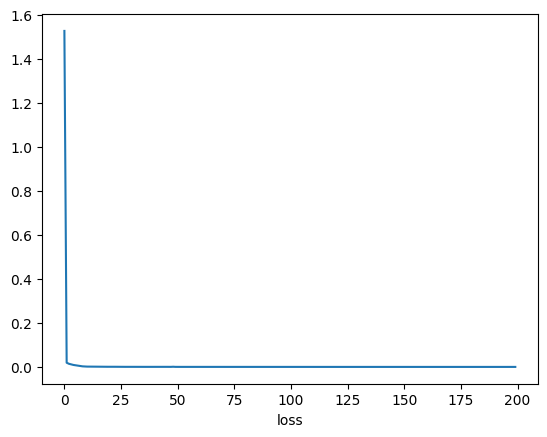

In [ ]:
epochs = 200
losses = []

# ミニバッチ学習
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in loader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"{epoch + 1}: {total_loss}")

plt.plot(losses)
plt.xlabel("loss")
plt.show()

In [ ]:
# モデルの評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

y_test = y_test.numpy()

# 1次元の予測値を3次元に拡張して逆変換
_y_pred = np.zeros((len(y_pred), 6))
_y_pred[:, 0] = y_pred.flatten()
y_pred_inverted = scaler.inverse_transform(_y_pred)[:, 0:1]

# テストデータも同様
_y_test = np.zeros((len(y_test), 6))
_y_test[:, 0] = y_test.flatten()
y_test_inverted = scaler.inverse_transform(_y_test)[:, 0:1]

# 誤差計算
# MSE; Mean Squared Error, 平均二乗誤差
mse_inv = np.mean((y_pred_inverted - y_test_inverted) ** 2)
# RMSE; Root Mean Squared, ErrorMSEの平方根
rmse_inv = np.sqrt(mse_inv)
# MAPE; Mean Absolute Percentage Error, 平均絶対パーセント誤差
mape = np.mean(np.abs((y_pred_inverted - y_test_inverted) / y_test_inverted))

mse_inv, rmse_inv, mape

(np.float64(0.45504139097803065),
 np.float64(0.6745675584980578),
 np.float64(0.0026247431188560267))

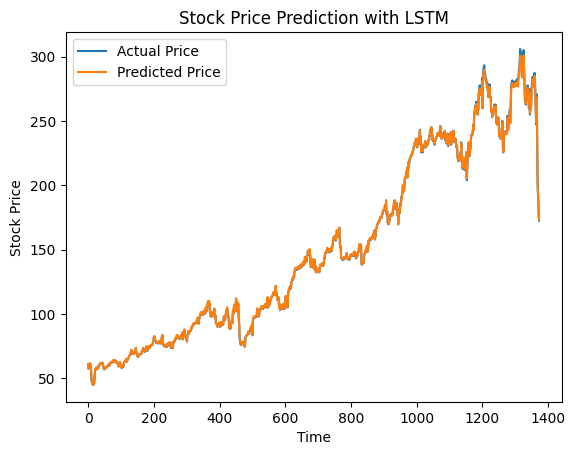

In [ ]:
plt.plot(y_test_inverted, label="Actual Price")
plt.plot(y_pred_inverted, label="Predicted Price")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.show()